### Import the model from source

In [1]:
import stardist
import csbdeep
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

2022-04-12 22:42:22.473013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 22:42:22.473061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
def get_model():
    return StarDist2D.from_pretrained('2D_versatile_he')
def test_model(model, image, prints = False, return_render=False):
    # coord is y,x --> same with point
    labels, instance_data = model.predict_instances(normalize(image))
    predictions_render = render_label(labels, img=image)
    if prints:
        print([(k, v.shape) for k,v in instance_data.items()])
        print(instance_data['coord'][0, :, :])
        print(instance_data['points'][0, :])
        print(min(instance_data['coord'][0,0,:]), min(instance_data['coord'][0,1,:]))
        print(max(instance_data['coord'][0,0,:]), max(instance_data['coord'][0,1,:]))
        print(instance_data['prob'][0])
        plt.imshow(predictions_render[284:308, 70:150, :])
    if return_render:
        return instance_data, predictions_render
    else:
        return instance_data

### Show the model in action

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from unified_image_reader import Image

In [8]:
def get_realistic_region(prints = False):
    img = Image("/workspaces/dev-container/testing/training-simple/test-wsi/0/84429T_003.tif")
    region = img.get_region((21300, 12000), region_dims=(512,512))
    if prints:
        print(img.dims)
        print(region.shape)
        plt.imshow(region)
    return region
def get_current_test_region(prints = False):
    img_path = "/workspaces/dev-container/testing/training-simple/test-wsi/0/84429T_003.tif"
    img = Image(img_path)
    region = img.get_region(5)
    if prints:
        plt.imshow(region)
    return region

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('coord', (78, 2, 32)), ('points', (78, 2)), ('prob', (78,))]
[[296.       298.13824  300.20203  301.95     303.6616   305.02798
  306.36093  306.94733  307.80594  307.17456  306.77258  305.2892
  303.54196  301.63055  299.79837  297.80273  296.       294.19562
  292.18076  290.18823  288.0737   286.40353  284.96286  284.82672
  284.54596  285.3111   285.79117  286.86584  288.10004  289.67825
  291.54694  293.78506 ]
 [ 91.34393   90.74961   90.14456   88.904816  87.66159   86.03231
   84.29163   82.17756   80.        77.77724   75.53784   73.79315
   72.45802   71.57327   70.82993   70.93702   70.50157   70.928764
   70.779526  71.30206   72.0737    73.58785   75.42827   77.7775
   80.        82.12616   84.228645  86.10324   87.899956  89.46116
   90.750626  91.13529 ]]
[296  80]
284.54596 70.50157
307.80594 91.34393
0.91593885


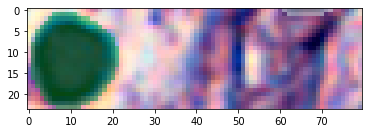

In [11]:
model = get_model()
image = get_realistic_region()
instance_data = test_model(model, image, prints=True)

### Save model into model manager

In [14]:
from cell_level import segmentation, instance

In [55]:
class WrappedStarDistModel(segmentation.ManagedModel):
    def __init__(self):
        self.model = None
    def get_instances(self, image, also_return=None):
        if self.model is None:
            import stardist
            from stardist import models
            self.model = models.StarDist2D.from_pretrained('2D_versatile_he')
        from csbdeep.utils import normalize
        whole_mask, instance_data = self.model.predict_instances(normalize(image))
        instances = self.raw_predictions_to_instances(instance_data, image)
        if also_return is None:
            return instances
        else:
            return_data = [instances]
            if 'whole_mask' in also_return:
                return_data.append(whole_mask)
            if 'mask_render' in also_return:
                return_data.append(stardist.plot.render_label(whole_mask, img=region))
        return return_data

    def raw_predictions_to_instances(self, instance_data, image):
        from cell_level import instance
        instances = []
        for i, prob in enumerate(instance_data['prob']):
            points_x = np.clip(instance_data['coord'][i,1,:].astype(int), 0, image.shape[1])
            points_y = np.clip(instance_data['coord'][i,0,:].astype(int), 0, image.shape[0])
            instance_image = image[
                    min(points_y) : max(points_y),
                    min(points_x) : max(points_x),
                    :
                ]
            instances.append(instance.Instance(
                points = {'x': points_x, 'y': points_y},
                image = instance_image,
                score = prob
            ))
        return instances
        
wrapped_model = WrappedStarDistModel()

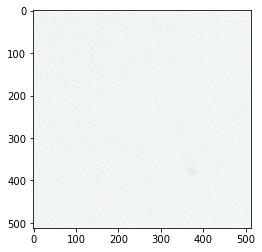

In [56]:
region = get_current_test_region(prints=True)

In [57]:
instances, whole_mask, mask_render = wrapped_model.get_instances(region, also_return=['whole_mask', 'mask_render'])
len(instances)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


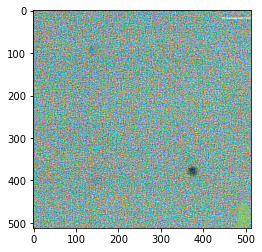

In [58]:
plt.imshow(mask_render)

(479, 451, 510, 512)
(61, 31)


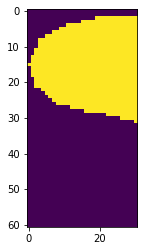

In [59]:
box = instance.util.get_box_from_points(
    instances[0].data['points']['x'],
    instances[0].data['points']['y']
)
print(box)
mask = instance.util.construct_mask_from_points(
    instances[0].data['points']['x'],
    instances[0].data['points']['y'],
    box
)
print(mask.shape)
plt.imshow(mask)

(61, 31, 3)

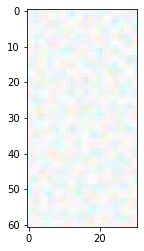

In [60]:
instance_num = 0
plt.imshow(instances[instance_num].image)
instances[instance_num].image.shape

(61, 31)

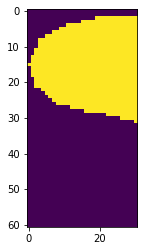

In [61]:
plt.imshow(instances[instance_num].mask)
instances[instance_num].mask.shape

In [62]:
model_manager = segmentation.ModelManager()
model_manager.save_model(
    model = WrappedStarDistModel(),
    model_name = "StarDist",
    model_info = {
        "source": "https://pypi.org/project/stardist/"
    },
    overwrite_model = True,
    dependency_modules = [
        stardist,
        stardist.models,
        csbdeep
    ]
)